## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Create a deep learning model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report


**QUESTION:** Load dataset and display some lines of the csv file.

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset from Google Drive
dataset_path = "/content/drive/MyDrive/Colab Notebooks/data/ai4i2020.csv"
df = pd.read_csv(dataset_path)

# Display first few rows
print("Dataset Head:")
print(df.head())

# Display dataset shape
print("\nDataset Shape:", df.shape)

Mounted at /content/drive
Dataset Head:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0



```
# Ce texte est au format code
```

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

<ipython-input-3-b6f2c28109fd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Machine failure'], palette='viridis')


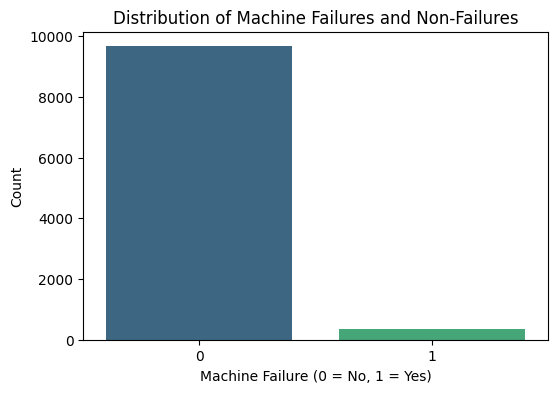

In [3]:
# Plot distribution of machine failures
plt.figure(figsize=(6,4))
sns.countplot(x=df['Machine failure'], palette='viridis')
plt.xlabel("Machine Failure (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.title("Distribution of Machine Failures and Non-Failures")
plt.show()

**ANALYSIS QUESTION:** What do you observe?

The dataset is highly imbalanced, with far more non-failure cases than failure cases. This imbalance may cause a predictive model to favor non-failures, making failure detection challenging. Techniques like oversampling, undersampling, or class weighting may be needed to improve model performance.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?



The class imbalance will cause the model to bias toward non-failures, leading to:

- Poor failure detection – The model may predict non-failure (0) most of the time, ignoring rare failure cases.
- High accuracy but low recall for failures – The overall accuracy might be high, but the model will struggle to correctly identify failures.
- Need for balancing techniques – Oversampling, undersampling, or class weighting will be necessary to improve failure prediction.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

<ipython-input-4-c1d8fb8f6550>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette='muted')


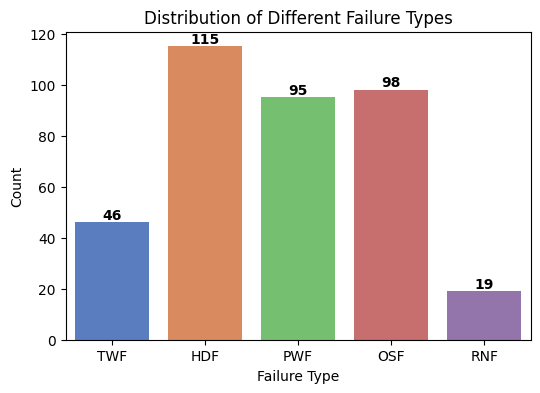

In [4]:
# Plot distribution of different failure types
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df[failure_types].sum()

plt.figure(figsize=(6,4))
bars = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette='muted')
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.title("Distribution of Different Failure Types")

# Display exact values above bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()),
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

**ANALYSIS QUESTION:** What do you observe?

From the bar chart, we observe:

- Imbalanced Failure Types

- Some failure types (HDF, OSF, and PWF) occur more frequently than others (TWF and RNF).
Random Failures (RNF) are the rarest, making them harder to predict accurately.
Impact on Model Learning

- The model may struggle to learn patterns for rare failure types, potentially misclassifying them.
Data balancing techniques (e.g., oversampling or weighted loss functions) may be required to improve prediction performance.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

<ipython-input-5-b1151317047a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=failure_counts_failed.index, y=failure_counts_failed.values, palette='pastel')


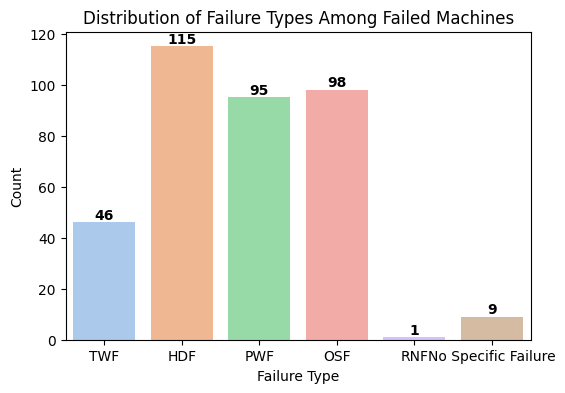

In [5]:
# Plot distribution of failure types among machines that failed
failed_machines = df[df['Machine failure'] == 1]
failure_counts_failed = failed_machines[failure_types].sum()

# Count cases where a machine failed but no specific failure type was recorded
no_specific_failure = failed_machines[(failed_machines[failure_types].sum(axis=1) == 0)].shape[0]

# Append 'No Specific Failure' category using pandas concat (since append is deprecated)
failure_counts_failed = pd.concat([failure_counts_failed, pd.Series({'No Specific Failure': no_specific_failure})])

plt.figure(figsize=(6,4))
bars = sns.barplot(x=failure_counts_failed.index, y=failure_counts_failed.values, palette='pastel')
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.title("Distribution of Failure Types Among Failed Machines")

# Display exact values above bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()),
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()


**ANALYSIS QUESTION:** What do you observe compared to the previous question ? What can you conclude?



- Key difference: The first analysis included all machines, while this one focuses only on failed machines.
- Observations: HDF, OSF, and PWF are the most frequent failures. RNF is extremely rare (only 1 case).
New insight: 9 failed machines have no recorded failure type, suggesting missing labels or unidentified failures.
- Conclusion: The model may struggle with rare failure types and "No Specific Failure" cases, requiring data balancing or label refinement.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [6]:
# Display column names and data types
print("\nDataset Columns and Data Types:")
print(df.dtypes)


Dataset Columns and Data Types:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

### **Inputs and Outputs for Model Training**  

#### **Inputs (Features)**
We will use the machine’s **operating conditions and sensor data** as input features:  
- **Air temperature [K]**  
- **Process temperature [K]**  
- **Rotational speed [rpm]**  
- **Torque [Nm]**  
- **Tool wear [min]**  
- **Type** (Categorical, requires encoding)

**Justification:**  
From previous analyses, we observed that failures are **correlated** with operating conditions. Machines with high **tool wear, torque, or temperature variations** are more prone to failure.

#### **Outputs (Targets)**
We need to predict:  
1. **Whether a failure will occur** → `Machine failure` (Binary: 0 = No, 1 = Yes)  
2. **If a failure occurs, what type it is** → `TWF, HDF, PWF, OSF, RNF` (Multilabel classification)

**Justification:**  
- The **bar charts showed class imbalance**, meaning some failure types occur more frequently.  
- The **"No Specific Failure"** category indicated that `Machine failure` can be **1 even when no failure type is flagged**, suggesting a need for both tasks:  
  - **Step 1:** Predict if failure will occur (`Machine failure`).  
  - **Step 2:** If failure happens, classify the type (`TWF, HDF, PWF, OSF, RNF`).  

### **Conclusion**  
We will **first train the model to predict failures** and then **classify failure types when a failure is detected**. This **two-step approach** ensures better accuracy for failure detection and diagnosis.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [7]:
# Prepare data for model training
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
target = ['Machine failure']

X = df[features]
Y = df[target]

# Split dataset into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the number of elements in each set
print("\nTraining set size:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("\nTesting set size:")
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)



Training set size:
X_train: (8000, 5)
Y_train: (8000, 1)

Testing set size:
X_test: (2000, 5)
Y_test: (2000, 1)


**QUESTION** Code below the model architecture

In [8]:
# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,881 (11.25 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 192 (768.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6865 - loss: 0.6570 - val_accuracy: 0.9695 - val_loss: 0.2033
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9345 - loss: 0.2505 - val_accuracy: 0.9695 - val_loss: 0.1341
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9558 - loss: 0.1661 - val_accuracy: 0.9700 - val_loss: 0.1135
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9606 - loss: 0.1381 - val_accuracy: 0.9655 - val_loss: 0.1520
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9638 - loss: 0.1296 - val_accuracy: 0.7830 - val_loss: 0.4614
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9649 - loss: 0.1211 - val_accuracy: 0.8405 - val_loss: 0.3585
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9645 - loss: 0.1204 - val_accuracy: 0.4630 - val_loss: 0.9965
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9640 - loss: 0.1246 - val_accuracy: 0.

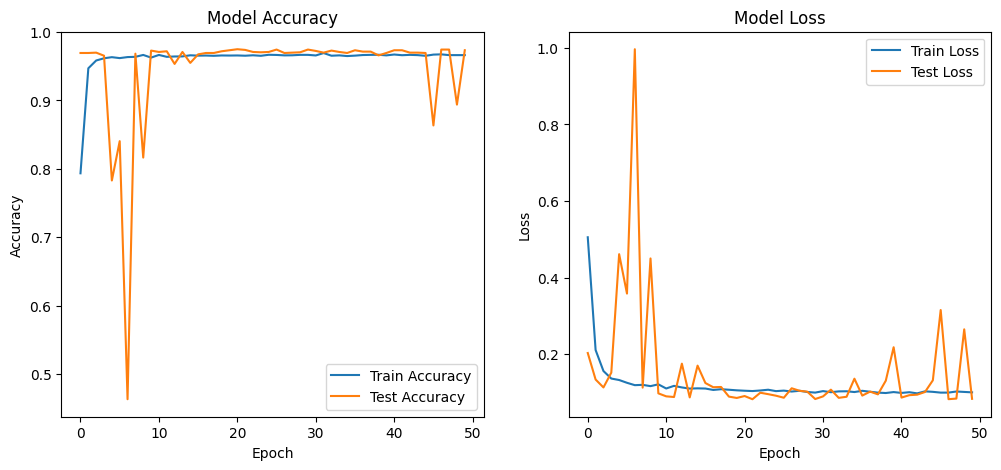

In [9]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=32)

# Plot training history
plt.figure(figsize=(12,5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [19]:
# Evaluate the model on the test set
test_results = model.evaluate(
    X_test,
    {'binary_output': Y_binary_test, 'multiclass_output': Y_multiclass_test},
    verbose=0
)

# Extract test loss and test accuracy
binary_test_loss = test_results[1]  # Binary classification loss
binary_test_accuracy = test_results[3]  # Binary classification accuracy

multiclass_test_loss = test_results[2]  # Multiclass classification loss
multiclass_test_accuracy = test_results[4]  # Multiclass classification accuracy

# Print the results
print("Test Results:")
print(f"Binary Classification - Loss: {binary_test_loss:.4f}, Accuracy: {binary_test_accuracy:.4f}")
print(f"Multiclass Classification - Loss: {multiclass_test_loss:.4f}, Accuracy: {multiclass_test_accuracy:.4f}")

Test Results:
Binary Classification - Loss: 0.0910, Accuracy: 0.9720
Multiclass Classification - Loss: 0.1001, Accuracy: 0.0155


**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

**QUESTION** Code below the algorithms allowing to train model


**QUESTION** Plot the confusion matrix and the classification report

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"